In [1]:
import torch
import torch.nn.functional as F
from utils import Linear, Sigmoid, Sequential
import matplotlib.pyplot as plt
%matplotlib inline


torch.manual_seed(12046)
# 为了讨论的方便，我们将神经网络扩大
n_hidden = 100
model = Sequential([
    Linear(2, n_hidden), Sigmoid(),
    Linear(n_hidden, n_hidden), Sigmoid(),
    Linear(n_hidden, n_hidden), Sigmoid(),
    Linear(n_hidden, n_hidden), Sigmoid(),
    Linear(n_hidden, 2)
    ])

# 对于模型参数，需要记录它们的梯度（为反向传播做准备）
for p in model.parameters():
    p.requires_grad = True

In [2]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
import numpy as np

# 生成训练数据并对数据做归一化处理
np.random.seed(12046)
data = make_moons(n_samples=2000, noise=.05)
scaler = StandardScaler()
data = (scaler.fit_transform(data[0]), data[1])

In [3]:
def train_model(max_steps):
    batch_size = 2000
    lossi = []
    # 记录各层的参数更新幅度
    udi = {}
    x, y = torch.tensor(data[0]).float(), torch.tensor(data[1])
    _prob = torch.ones(x.shape[0]) / x.shape[0]

    for i in range(max_steps):
        # 构造批次训练数据
        ## 不放回的随机抽样
        ix = _prob.multinomial(batch_size)
        xb = x[ix]
        yb = y[ix]
        # 向前传播
        logits = model(xb)
        loss = F.cross_entropy(logits, yb)
        # 保留中间节点的梯度，以便观察
        for layer in model.layers:
            layer.out.retain_grad()
        for p in model.parameters():
            p.grad = None
        # 反向传播
        loss.backward()
        # 更新模型参数
        ## 学习速率衰减
        learning_rate = 0.1 if i < 20000 else 0.01
        with torch.no_grad():
            for i, p in enumerate(model.parameters()):
                p -= learning_rate * p.grad
                udi[i] = udi.get(i, []) + [(learning_rate * p.grad).std() / p.std()]
        lossi.append(loss.item())
    return lossi, udi

In [4]:
# 初始化时模型损失和各层的参数更新幅度
train_model(1)

([4.158403396606445],
 {0: [tensor(0.0171)],
  1: [tensor(0.0194)],
  2: [tensor(0.0064)],
  3: [tensor(0.0122)],
  4: [tensor(0.0059)],
  5: [tensor(0.0091)],
  6: [tensor(0.0063)],
  7: [tensor(0.0088)],
  8: [tensor(0.0306)],
  9: [tensor(0.5987)]})

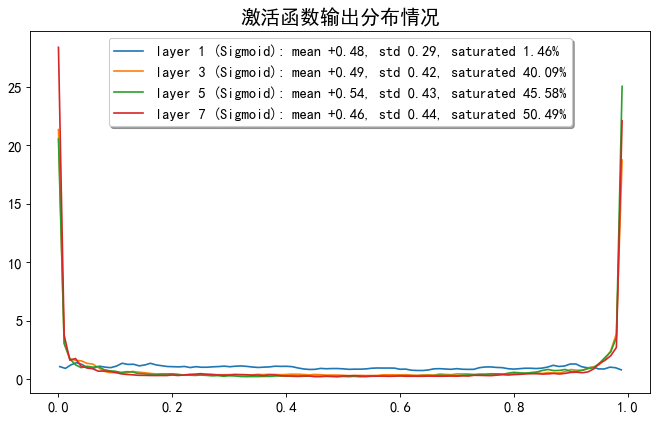

In [5]:
# 观察激活函数的状态
plt.figure(figsize=(10, 6), dpi=80)
# 解决中文显示的问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams.update({'font.size': 13})
legends = []
for i, layer in enumerate(model.layers):
    if isinstance(layer, (Sigmoid)):
        t = layer.out
        # 激活函数的输出大于0.99或者小于0.01时，激活函数“过热”
        saturation = ((t - 0.5).abs() > 0.49).float().mean()
        # 激活函数输出的分布情况
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        layer_name = f'layer {i} ({layer.__class__.__name__})'
        stats = f'mean {t.mean():+.2f}, std {t.std():.2f}, saturated {saturation:.2%}'
        legends.append(f'{layer_name}: {stats}')
plt.legend(legends, shadow=True)
plt.title('激活函数输出分布情况', fontsize=18)
plt.savefig('activation_distribution.png', dpi=200)
plt.show()

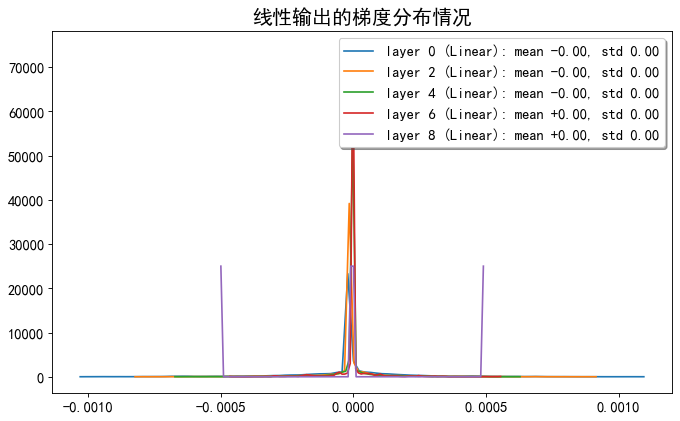

In [6]:
# 观察激活函数的状态
plt.figure(figsize=(10, 6), dpi=80)
# 解决中文显示的问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams.update({'font.size': 13})
legends = []
for i, layer in enumerate(model.layers):
    if isinstance(layer, (Linear)):
        t = layer.out.grad
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        layer_name = f'layer {i} ({layer.__class__.__name__})'
        stats = f'mean {t.mean():+.2f}, std {t.std():.2f}'
        legends.append(f'{layer_name}: {stats}')
plt.legend(legends, shadow=True)
plt.title('线性输出的梯度分布情况', fontsize=18)
plt.savefig('linear_grad_distribution.png', dpi=200)
plt.show()

layer 0   (2, 100): mean -0.0006, std 0.1712, grad ratio 0.17112263
layer 2 (100, 100): mean -0.0002, std 0.0648, grad ratio 0.06404040
layer 4 (100, 100): mean -0.0002, std 0.0597, grad ratio 0.05931355
layer 6 (100, 100): mean +0.0017, std 0.0631, grad ratio 0.06336858
layer 8   (100, 2): mean +0.0000, std 0.3122, grad ratio 0.30641049


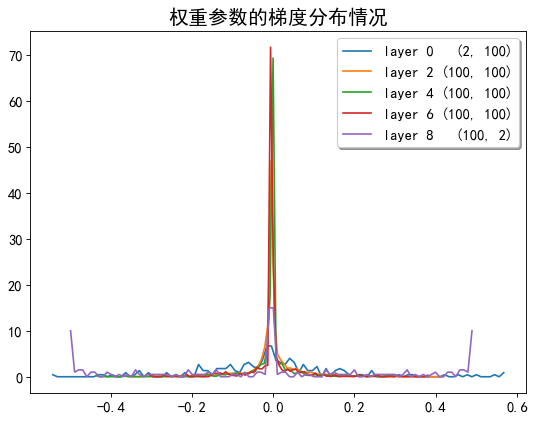

In [7]:
# 观察参数梯度的分布情况
fig = plt.figure(figsize=(8, 6), dpi=80)
ax = fig.add_subplot(111)
legends = []
for i, layer in enumerate(model.layers):
    if isinstance(layer, (Linear)):
        # 只观察权重参数，也就是w
        p = layer.parameters()[0]
        g = p.grad
        # 梯度标准差与参数标准差的比例
        grad_ratio = g.std() / p.std()
        hy, hx = torch.histogram(g, density=True)
        ax.plot(hx[:-1].detach(), hy.detach())
        layer_name = f'layer {i} {str(tuple(p.shape)):>10}'
        stats = f'mean {g.mean():+.4f}, std {g.std():.4f}, grad ratio {grad_ratio:.8f}'
        legends.append(f'{layer_name}')
        print(f'{layer_name}: {stats}')
ax.legend(legends, shadow=True)
ax.set_title('权重参数的梯度分布情况', fontsize=18)
fig.savefig('weight_grad_distribution.png', dpi=200)

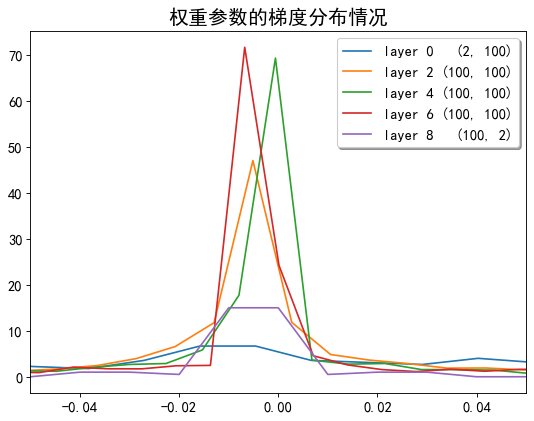

In [8]:
ax.set_xlim([-0.05, 0.05])
fig.savefig('weight_grad_distribution_zoom.png', dpi=200)
fig

In [9]:
_, ud = train_model(1000)

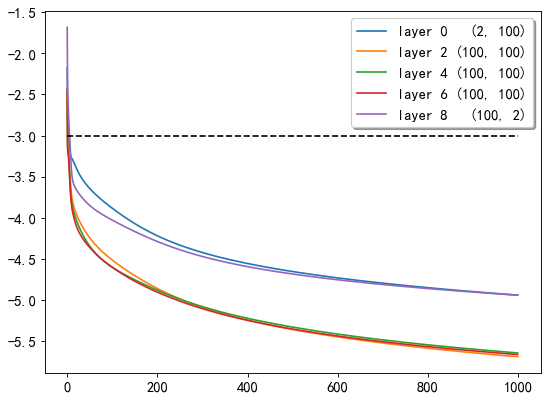

In [10]:
plt.figure(figsize=(8, 6), dpi=80)
legends = []
for i, p in enumerate(model.parameters()):
    # 只观察权重参数，也就是w
    if p.ndim == 2:
        plt.plot([t.log10().item() for t in ud[i]])
        legends.append(f'layer {i} {str(tuple(p.shape)):>10}')
# 理想的标准线
plt.plot([0, len(ud[0])], [-3, -3], 'k--')
plt.legend(legends, shadow=True)
plt.savefig('weights_grad_ratio.png', dpi=200)
plt.show()